# Sentence Similarity Demo (Newa NLP)

This notebook demonstrates sentence embeddings and similarity for Newari text using the Hugging Face model `sundeepdwd/muril-mlm-newa-finetuned`.

Model card: https://huggingface.co/sundeepdwd/muril-mlm-newa-finetuned

It will:
- Load the model and tokenizer via `newa_nlp.SentenceEncoder`
- Sample sentences from `corpus.csv`
- Compute embeddings and cosine similarity
- Show top-k similar sentences for random queries
- Allow you to compare any two sentences interactively


In [1]:
# Install dependencies if needed (uncomment if running in a fresh env)
# !pip install transformers==4.56.1 torch pandas

import os
import random
import pandas as pd
import torch

from newa_nlp import SentenceEncoder, tokenize_sentences, top_k_similar, cosine_similarity

print(f"Torch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


Torch device: cuda


In [2]:
# Load encoder
encoder = SentenceEncoder()
encoder


Some weights of BertModel were not initialized from the model checkpoint at sundeepdwd/muril-mlm-newa-finetuned and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# Sample sentences from corpus.csv

def sample_sentences_from_corpus(csv_path: str, sample_docs: int = 50, max_sentences: int = 200, min_len: int = 6):
    df = pd.read_csv(csv_path)
    assert 'content' in df.columns, "CSV must include 'content' column"
    if len(df) > sample_docs:
        df = df.sample(sample_docs, random_state=42)
    sents = []
    for content in df['content'].astype(str):
        for s in tokenize_sentences(content):
            if len(s.strip()) >= min_len:
                sents.append(s.strip())
                if len(sents) >= max_sentences:
                    break
        if len(sents) >= max_sentences:
            break
    return sents

if not os.path.exists('corpus.csv'):
    raise FileNotFoundError("corpus.csv not found in current directory")

sentences = sample_sentences_from_corpus('corpus.csv', sample_docs=80, max_sentences=200)
len(sentences)


200

In [4]:
# Encode and compute similarities for a few queries
embeddings = encoder.encode(sentences, batch_size=16)

# Pick 5 random queries from the set
import random
query_indices = random.sample(range(len(sentences)), k=min(5, len(sentences)))
queries = [sentences[i] for i in query_indices]
query_embs = embeddings[query_indices]

indices, scores = top_k_similar(query_embs, embeddings, k=10)

for qi, q_idx in enumerate(query_indices):
    print(f"Query {qi+1}: {sentences[q_idx]}")
    for rank, (idx, score) in enumerate(zip(indices[qi].tolist(), scores[qi].tolist()), start=1):
        print(f"  {rank}. ({score:.3f}) {sentences[idx]}")
    print()


Query 1: थनया परम्पराय्‌ आन्ध्र शास्त्रीय संगीत व प्याखं विशेषयाना कुचिपुडि नांजा
  1. (1.000) थनया परम्पराय्‌ आन्ध्र शास्त्रीय संगीत व प्याखं विशेषयाना कुचिपुडि नांजा
  2. (1.000) थनया परम्पराय्‌ आन्ध्र शास्त्रीय संगीत व प्याखं विशेषयाना कुचिपुडि नांजा
  3. (0.995) थन तेलुगु संकिपा व कर्नाटक संगीतया नं प्रभाव दु
  4. (0.995) थन तेलुगु संकिपा व कर्नाटक संगीतया नं प्रभाव दु
  5. (0.994) थ्व थासय्‌ चिकुलाय्‌ वातावरण बांलाइ
  6. (0.994) थ्व थासय्‌ चिकुलाय्‌ वातावरण बांलाइ
  7. (0.994) ल्वय्‌ सिक्क तःच्वसा वा याकनं सुधार यायेमाःसा इन्त्राभिनस फ्लुइद नं बी छिं
  8. (0.994) थ्व ल्वय् तःच्वया दिहाइद्रेसन जुया जलासें स्यंकी
  9. (0.993) थनया नसाःय्‌ पच्चडी, आवकाय आदि अचार नांजा
  10. (0.993) थनया नसाःय्‌ पच्चडी, आवकाय आदि अचार नांजा

Query 2: थ्व खँग्वःयागु  छ्येलेज्या येक्व सफू व स्तोत्रय् जुगु दु
  1. (1.000) थ्व खँग्वःयागु  छ्येलेज्या येक्व सफू व स्तोत्रय् जुगु दु
  2. (1.000) थ्व खँग्वःयागु  छ्येलेज्या येक्व सफू व स्तोत्रय् जुगु दु
  3. (0.997) खँग्वःयागु उत्पत्ति व छ्येलेज्या

उत्पत्ति व 

In [5]:
# Compare two custom sentences
s1 = "नेपाल भाषा नेवाः भाषा खः।"
s2 = "नेवाः भाषा नेपालया भाषा खः।"

emb = encoder.encode([s1, s2])
sim = cosine_similarity(emb[0:1], emb[1:2]).item()
print(f"Cosine similarity: {sim:.4f}")


Cosine similarity: 0.9991


In [7]:
sentences = sample_sentences_from_corpus('corpus.csv', sample_docs=100, max_sentences=400)
len(sentences)

400

In [9]:
embeddings = encoder.encode(sentences, batch_size=16)
embeddings.shape

torch.Size([400, 768])

In [10]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

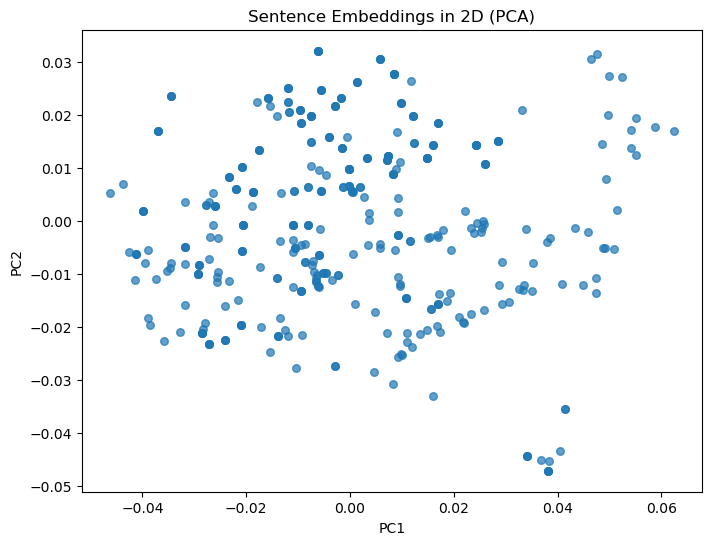

In [ ]:
# embeddings is torch.Size([400, 768])
# if it's a torch tensor, convert to numpy
emb_np = embeddings.numpy() if hasattr(embeddings, "numpy") else embeddings

# reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(emb_np)  # shape: [400, 2]

# plot
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], s=30, alpha=0.7)
plt.title("Sentence Embeddings in 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


c:\Users\Nitro 5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Nitro 5\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Nitro 5\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Nitro 5\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^

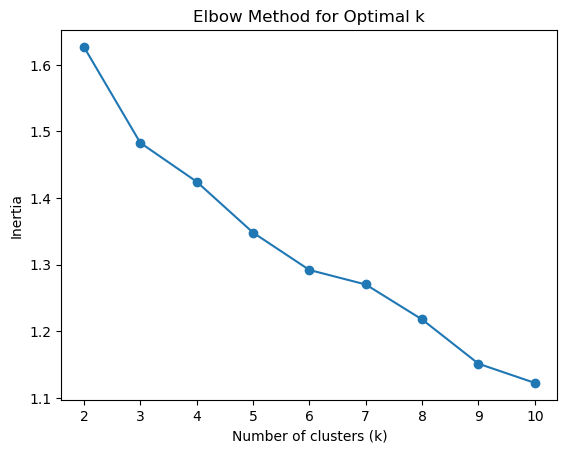

In [11]:
inertias = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    inertias.append(km.inertia_)

plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()